# Detección de vocales

Pre-procesamiento

In [14]:
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Configuración
N_FRECUENCIAS = 5  # Para vocales, 5 funciona mejor
CARPETA_MUESTRAS = "RUTA"

def obtener_frecuencias_dominantes(audio, sr, n=N_FRECUENCIAS):
    # Convertir a mono si es estéreo
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)
    # Normalizar señal de audio
    audio = audio / np.max(np.abs(audio))
    # Aplicar FFT
    fft_values = np.abs(fft(audio))
    freqs = fftfreq(len(audio), d=1/sr)
    # Filtrar frecuencias negativas
    fft_values = fft_values[freqs > 0]
    freqs = freqs[freqs > 0]
    # Ignorar ruido bajo
    umbral = np.max(fft_values) * 0.01  # 1% del valor máximo
    fft_values[fft_values < umbral] = 0
    # Obtener las n frecuencias más altas
    indices = np.argsort(fft_values)[-n:]  # Índices de mayores valores
    freqs_dominantes = freqs[indices]
    # Ordenar por frecuencia
    return np.sort(freqs_dominantes)

# Leer todas las muestras
muestras_procesadas = []
etiquetas = []

for archivo in os.listdir(CARPETA_MUESTRAS):
    if archivo.endswith(".wav"):
        try:
            # Leer archivo de audio
            sr, audio = wavfile.read(os.path.join(CARPETA_MUESTRAS, archivo))
            freqs_dominantes = obtener_frecuencias_dominantes(audio, sr)
            muestras_procesadas.append(freqs_dominantes)
            etiquetas.append(archivo[0].upper())  # Suponiendo que la vocal está en el nombre
            print(f"Archivo: {archivo}, Frecuencias Dominantes: {freqs_dominantes}")
        except Exception as e:
            print(f"Error procesando el archivo {archivo}: {e}")

# Convertir a matriz
muestras_procesadas = np.array(muestras_procesadas)
etiquetas = np.array(etiquetas)

print("Muestras procesadas:", muestras_procesadas)
print("Etiquetas:", etiquetas)


Archivo: a_12.wav, Frecuencias Dominantes: [1545.83333333 1546.35416667 1546.875      1547.39583333 1547.91666667]
Archivo: a_17.wav, Frecuencias Dominantes: [1577.60416667 1578.125      1578.64583333 1579.16666667 1579.6875    ]
Archivo: a_2.wav, Frecuencias Dominantes: [1481.25       1481.77083333 1482.29166667 1482.8125     1483.33333333]
Archivo: a_22.wav, Frecuencias Dominantes: [ 205.72916667 1026.04166667 1026.5625     1027.08333333 1027.60416667]
Archivo: a_37.wav, Frecuencias Dominantes: [194.27083333 194.79166667 195.3125     195.83333333 196.35416667]
Archivo: a_42.wav, Frecuencias Dominantes: [1018.22916667 1018.75       1019.27083333 1019.79166667 1020.3125    ]
Archivo: a_47.wav, Frecuencias Dominantes: [1033.33333333 1033.85416667 1034.375      1034.89583333 1035.41666667]
Archivo: a_52.wav, Frecuencias Dominantes: [192.1875     192.70833333 193.22916667 193.75       194.27083333]
Archivo: a_7.wav, Frecuencias Dominantes: [1004.6875     1005.20833333 1005.72916667 1006.2

In [15]:
from collections import Counter

print(Counter(etiquetas).keys())
print(Counter(etiquetas).values()) 

dict_keys(['A', 'E', 'I', 'O', 'U'])
dict_values([9, 12, 11, 11, 11])


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models


In [17]:
# scaling 
scaler = StandardScaler()
scaler.fit(muestras_procesadas)
muestras_normalizadas = scaler.transform(muestras_procesadas)

encoder = LabelEncoder()
etiquetas_codificadas = encoder.fit_transform(etiquetas)


Red Neuronal

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(muestras_normalizadas, etiquetas_codificadas, test_size=0.1, random_state=42)

# modelo de red neuronal
model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(N_FRECUENCIAS,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# entrenamiento
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1)

# evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en pruebas: {test_acc}")


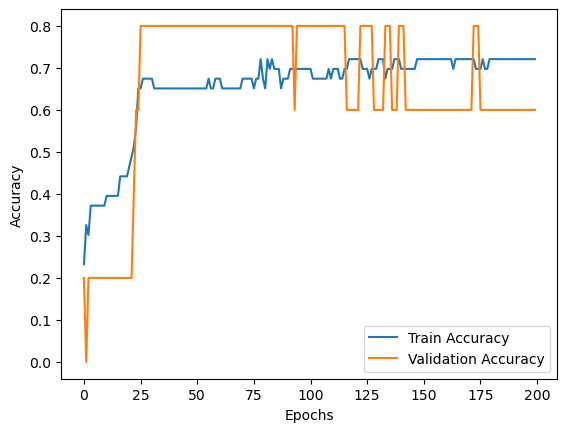

In [464]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
import numpy as np
from sklearn.metrics import accuracy_score

# obenter precisón de prueba por clase

predictions = np.argmax(model.predict(X_train), axis=1)

classes = np.unique(y_train)
class_accuracies = {}

for cls in classes:
    cls_indices = np.where(y_train == cls)
    cls_true = y_train[cls_indices]
    cls_pred = predictions[cls_indices]
    
    # precisión de clase
    class_accuracy = accuracy_score(cls_true, cls_pred)
    class_accuracies[cls] = class_accuracy

print("Precisión de entrenamiento por clase:")
for cls, acc in class_accuracies.items():
    print(f"Class {cls}: {acc:.2%}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Precisión de entrenamiento por clase:
Class 0: 75.00%
Class 1: 50.00%
Class 2: 100.00%
Class 3: 63.64%
Class 4: 62.50%


In [ ]:
import pickle
# guardar modelo si es necesario
filename = 'vocal_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [ ]:
import pickle
# cargar modelo
filename = 'vocal_model.sav'
model = pickle.load(open(filename, 'rb'))

Pruebas

In [36]:
import numpy as np
import pyaudio

# antes de correr esto N_FRECUENCIAS y el scaler deben estar definidos correctamente


def detectar_vocales(audio_data, sr):
    freqs_dominantes = obtener_frecuencias_dominantes(audio_data, sr)


    freqs_dominantes =  scaler.transform(freqs_dominantes.reshape(1,-1)) 
    #print(freqs_dominantes)
    
    prediccion = model.predict(freqs_dominantes)
    prediccion = np.argmax(prediccion)
    
    vocal = encoder.inverse_transform([prediccion])
    return vocal

def grabar_audio(duracion_segundos=2, tasa_muestreo=8000, canales=1, chunk=1024):
    FORMAT = pyaudio.paInt16

    
    audio = pyaudio.PyAudio()

    stream = audio.open(format=FORMAT, channels=canales, rate=tasa_muestreo, input=True, frames_per_buffer=chunk)
    print("Grabando audio...")

    frames = []
    for _ in range(0, int(tasa_muestreo / chunk * duracion_segundos)):
        data = stream.read(chunk)
        frames.append(data)

    print("Grabación terminada")

    stream.stop_stream()
    stream.close()
    audio.terminate()

    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)
    return audio_data, tasa_muestreo


audio_data, sr = grabar_audio(duracion_segundos=2, tasa_muestreo=8000)
vocal = detectar_vocales(audio_data, sr)
print(f"La vocal detectada es: {vocal}")


Grabando audio...
Grabación terminada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4
La vocal detectada es: ['U']


# Detección de palabras

Pre-procesamiento

In [ ]:
N_FRECUENCIAS = 10  # para palabras, 10 funciona mejor
CARPETA_MUESTRAS = "RUTA"

def obtener_frecuencias_dominantes(audio, sr, n=N_FRECUENCIAS):
    # Convertir a mono si es estéreo
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)
    # Normalizar señal de audio
    audio = audio / np.max(np.abs(audio))
    # Aplicar FFT
    fft_values = np.abs(fft(audio))
    freqs = fftfreq(len(audio), d=1/sr)
    # Filtrar frecuencias negativas
    fft_values = fft_values[freqs > 0]
    freqs = freqs[freqs > 0]
    # Ignorar ruido bajo
    umbral = np.max(fft_values) * 0.01  # 1% del valor máximo
    fft_values[fft_values < umbral] = 0
    # Obtener las n frecuencias más altas
    indices = np.argsort(fft_values)[-n:]  # Índices de mayores valores
    freqs_dominantes = freqs[indices]
    # Ordenar por frecuencia
    return np.sort(freqs_dominantes)

# Leer todas las muestras
muestras_procesadas = []
etiquetas = []

for archivo in os.listdir(CARPETA_MUESTRAS):
    if archivo.endswith(".wav"):
        try:
            # Leer archivo de audio
            sr, audio = wavfile.read(os.path.join(CARPETA_MUESTRAS, archivo))
            freqs_dominantes = obtener_frecuencias_dominantes(audio, sr)
            muestras_procesadas.append(freqs_dominantes)
            etiquetas.append(archivo[0].upper())  # l si es libro a si es agua
            print(f"Archivo: {archivo}, Frecuencias Dominantes: {freqs_dominantes}")
        except Exception as e:
            print(f"Error procesando el archivo {archivo}: {e}")

# Convertir a matriz
muestras_procesadas = np.array(muestras_procesadas)
etiquetas = np.array(etiquetas)
etiquetas = ["libro" if e == "L" else "agua" for e in etiquetas]

print("Muestras procesadas:", muestras_procesadas)
print("Etiquetas:", etiquetas)

Archivo: agua_11.wav, Frecuencias Dominantes: [368.75       369.27083333 369.79166667 370.3125     370.83333333
 406.25       406.77083333 407.29166667 407.8125     408.33333333]
Archivo: agua_12.wav, Frecuencias Dominantes: [ 371.35416667  371.875       372.39583333  372.91666667  373.4375
  373.95833333  374.47916667  375.         1029.6875     1030.20833333]
Archivo: agua_13.wav, Frecuencias Dominantes: [354.6875     355.20833333 355.72916667 356.25       356.77083333
 357.29166667 357.8125     358.33333333 358.85416667 359.375     ]
Archivo: agua_14.wav, Frecuencias Dominantes: [396.875      397.39583333 397.91666667 398.4375     398.95833333
 399.47916667 400.         400.52083333 401.04166667 402.08333333]
Archivo: agua_15.wav, Frecuencias Dominantes: [370.3125     370.83333333 371.35416667 371.875      372.39583333
 376.04166667 376.5625     377.08333333 377.60416667 378.125     ]
Archivo: agua_16.wav, Frecuencias Dominantes: [369.79166667 370.3125     370.83333333 371.35416667 

In [ ]:
scaler = StandardScaler()
scaler.fit(muestras_procesadas)
muestras_normalizadas = scaler.transform(muestras_procesadas)

encoder = LabelEncoder()
etiquetas_codificadas = encoder.fit_transform(etiquetas)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    muestras_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42
)


Modelo de regresión logística

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# entrenar modelo
word_model = LogisticRegression(solver='newton-cg' , max_iter=1000)
word_model.fit(X_train, y_train)

# predicción
y_pred = word_model.predict(X_test)

print(classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=encoder.classes_))


# validación cruzada
scores = cross_val_score(word_model, muestras_normalizadas, etiquetas_codificadas, cv=5, scoring='accuracy')
print(f"Mean Accuracy: {scores.mean():.2f}")


              precision    recall  f1-score   support

        agua       1.00      1.00      1.00         3
       libro       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Mean Accuracy: 0.78


In [481]:
import pickle
# guardar modelo si es necesario
filename = 'word_model.sav'
pickle.dump(word_model, open(filename, 'wb'))

In [19]:
import pickle
# cargar modelo
filename = 'word_model.sav'
word_model = pickle.load(open(filename, 'rb'))

Pruebas

In [ ]:
import numpy as np
import pyaudio

# antes de correr esto N_FRECUENCIAS y el scaler deben estar definidos correctamente

def detectar_palabras(audio_data, sr):
    freqs_dominantes = obtener_frecuencias_dominantes(audio_data, sr)


    freqs_dominantes =  scaler.transform(freqs_dominantes.reshape(1,-1)) 
    
    prediccion = word_model.predict(freqs_dominantes)
    palabra = encoder.inverse_transform(prediccion)
    return palabra

def grabar_audio(duracion_segundos=2, tasa_muestreo=8000, canales=1, chunk=1024):
    FORMAT = pyaudio.paInt16

    
    audio = pyaudio.PyAudio()

    stream = audio.open(format=FORMAT, channels=canales, rate=tasa_muestreo, input=True, frames_per_buffer=chunk)
    print("Grabando audio...")

    frames = []
    for _ in range(0, int(tasa_muestreo / chunk * duracion_segundos)):
        data = stream.read(chunk)
        frames.append(data)

    print("Grabación terminada")

    stream.stop_stream()
    stream.close()
    audio.terminate()

    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)
    return audio_data, tasa_muestreo

audio_data, sr = grabar_audio(duracion_segundos=2, tasa_muestreo=8000)
palabra = detectar_palabras(audio_data, sr)
print(f"La palabra detectada es: {palabra}")


Grabando audio...
Grabación terminada
La palabra detectada es: ['agua']
